In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.ensemble import RandomForestRegressor
import eli5
import xarray as xr
from eli5.sklearn import PermutationImportance
import os
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cdo


2022-12-04 21:28:53.365607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-04 21:28:53.828932: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-04 21:28:53.828969: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-04 21:28:55.747957: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

Données brutes

In [2]:
file1 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test1.csv'
file2 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test2.csv'
file3 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test3.csv'
file4 = '/home/enora/Documents/insa/IA/defi_IA-main/pricing_requests/pricing_requests_test4.csv'


In [3]:
file_list=[file1,file2,file3,file4]
  
dataset = pd.DataFrame(pd.read_csv(file_list[0]))
  
for i in range(1,len(file_list)):
    data = pd.read_csv(file_list[i])
    df = pd.DataFrame(data)
    dataset = pd.concat([dataset,df])

In [4]:
dataset.head()

,hotel_id,price,stock,city,date,language,mobile,avatar_id,group,brand,parking,pool,children_policy
0,918,336,23,amsterdam,14,dutch,0,59852,Morriott International,Corlton,1,1,0
1,442,190,19,amsterdam,14,dutch,0,59852,Accar Hotels,Marcure,0,0,0
2,588,173,0,amsterdam,14,dutch,0,59852,Independant,Independant,0,0,0
3,807,323,17,amsterdam,14,dutch,0,59852,Chillton Worldwide,Chill Garden Inn,0,1,0
4,271,81,0,amsterdam,14,dutch,0,59852,Independant,Independant,1,0,0


<AxesSubplot: >

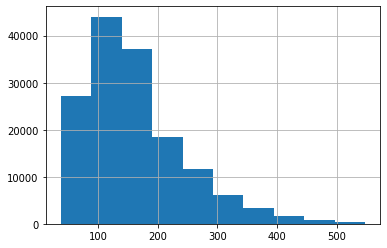

In [5]:
dataset['price'].hist()

array([[<AxesSubplot: xlabel='price', ylabel='price'>,
        <AxesSubplot: xlabel='stock', ylabel='price'>,
        <AxesSubplot: xlabel='date', ylabel='price'>],
       [<AxesSubplot: xlabel='price', ylabel='stock'>,
        <AxesSubplot: xlabel='stock', ylabel='stock'>,
        <AxesSubplot: xlabel='date', ylabel='stock'>],
       [<AxesSubplot: xlabel='price', ylabel='date'>,
        <AxesSubplot: xlabel='stock', ylabel='date'>,
        <AxesSubplot: xlabel='date', ylabel='date'>]], dtype=object)

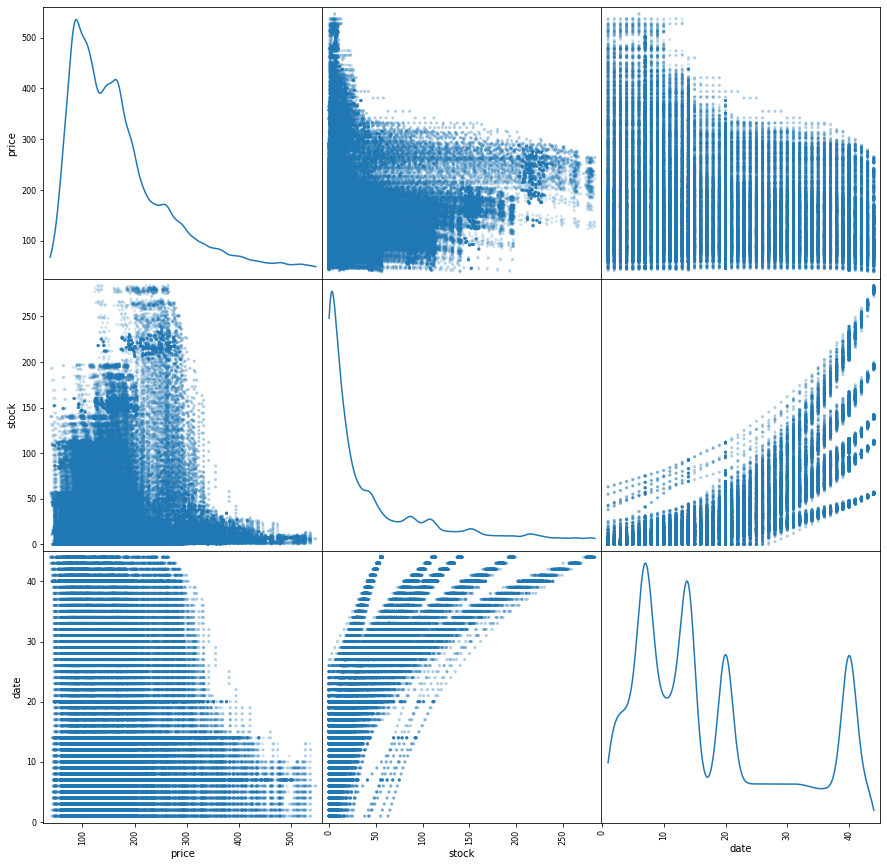

In [8]:
scatter_matrix(dataset[["price","stock","date"]], alpha=0.2, figsize=(15, 15), diagonal='kde')


Préparation des données

In [6]:
# Variables explicatives

#encodage avec OneHotEncoder

from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
enc_data=pd.DataFrame(enc.fit_transform(dataset[["city","language","group","brand"]]).toarray())
df_ohe=dataset.join(enc_data)
one_hot_encoded_data = pd.get_dummies(dataset, columns = ["city","language","group","brand"])

X_ohe = one_hot_encoded_data.drop(labels='price',axis=1)
Y_ohe = one_hot_encoded_data .price
X_ohe

,hotel_id,stock,date,mobile,avatar_id,parking,pool,children_policy,city_amsterdam,city_copenhagen,...,brand_Ibas,brand_Independant,brand_J.Halliday Inn,brand_Marcure,brand_Morriot,brand_Navatel,brand_Quadrupletree,brand_Royal Lotus,brand_Safitel,brand_Tripletree
0,918,23,14,0,59852,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,442,19,14,0,59852,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,588,0,14,0,59852,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,807,17,14,0,59852,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,271,0,14,0,59852,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38857,272,0,7,1,70507,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38858,353,13,7,1,70507,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
38859,304,19,7,1,70507,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
38860,145,7,7,1,70507,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


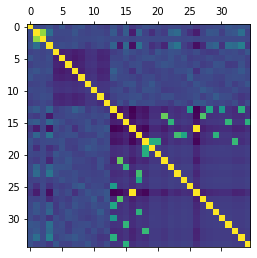

In [22]:
X_ohe.corr()
plt.matshow(X_ohe.corr())
plt.show()

In [31]:
from category_encoders import TargetEncoder

1. Target encoding: each level of categorical variable is represented by a summary statistic of the target for that level.

2. One-hot encoding: assign 1 to specific category and 0 to other category and transform categorical variable to dummy variable.

### Extraction des échantillons apprentissage et test

In [7]:
from sklearn.model_selection import train_test_split  

X_train,X_test,Y_train,Y_test=train_test_split(X_ohe,Y_ohe,test_size=0.1)

### Modèle Random Forest 

In [13]:
rf = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(max_depth=10),
)

In [11]:
rf.fit(X_train, Y_train)
print(f"Random forest score: {rf.score(X_test, Y_test):.2f}")

Random forest score: 0.89


### Modèle XGBoost

In [15]:
from xgboost import XGBRegressor

xgb = XGBRegressor()

In [29]:
xgb.fit(X_train,Y_train)
print(f"XGBoost score: {xgb.score(X_test, Y_test):.2f}")

XGBoost score: 0.98


### Feature Importance

In [41]:
feature_names = list(X_ohe.columns.values)
#feature_names

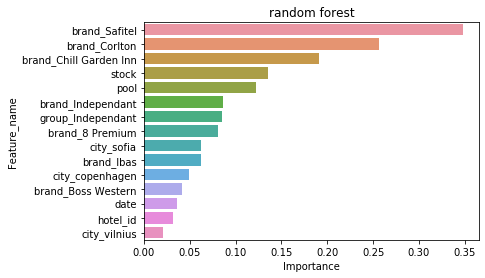

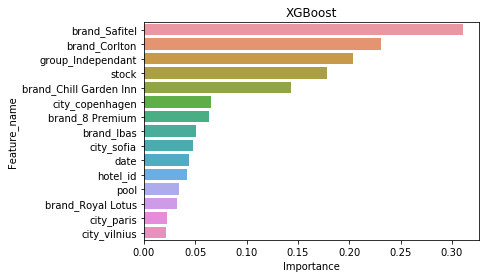

In [32]:
import seaborn as sns

features_importance_dict = {}
for model, name in zip([rf,xgb], ['random forest','XGBoost']):
    plt.figure()
    permumtation_impor = PermutationImportance(model, random_state=0).fit(X_test, Y_test)
    features_importance = {'Feature_name':feature_names, 'Importance':permumtation_impor.feature_importances_}  
    features_importance = pd.DataFrame(features_importance) 
    features_importance = features_importance.sort_values(['Importance'], ascending=False) 
    features_importance_dict[name] = features_importance
    ax = sns.barplot(x="Importance", y="Feature_name", data=features_importance[0:15])
    plt.title(name)

In [33]:
features_importance_dict['random forest']

,Feature_name,Importance
64,brand_Safitel,3.478456e-01
54,brand_Corlton,2.562229e-01
53,brand_Chill Garden Inn,1.914547e-01
1,stock,1.356856e-01
6,pool,1.225063e-01
...,...,...
51,brand_Ardisson,0.000000e+00
65,brand_Tripletree,0.000000e+00
28,language_german,-1.179208e-08
20,language_croatian,-2.857248e-07


In [35]:
Feature_name = features_importance_dict['random forest']['Feature_name'].tolist()
Importance = features_importance_dict['random forest']['Importance'].tolist()

Feature_name2 = ['city','language', 'group','brand','hotel_id','stock','date','mobile','avatar_id','parking','pool','children_policy']
Importance2 = [0 for i in range(len(Feature_name2))]

for i in range(len(Feature_name)):
    if Feature_name[i][0:4]=='city':
        Importance2[0]=Importance2[0]+Importance[i]
    
    if Feature_name[i][0:8]=='language':
        Importance2[1]=Importance2[1]+Importance[i]  
   
    if Feature_name[i][0:5]=='group':
        Importance2[2]=Importance2[2]+Importance[i]  
        
    if Feature_name[i][0:5]=='brand':
        Importance2[3]=Importance2[3]+Importance[i]  

for j in range(4,len(Feature_name2)):
    Importance2[j]= Importance[Feature_name.index(Feature_name2[j])]     
        
Importance2      
features_importance2 = pd.DataFrame(list(zip(Feature_name2, Importance2)),columns =['Feature_name2', 'Importance2'])
features_importance2


,Feature_name2,Importance2
0,city,0.165448
1,language,0.000358
2,group,0.084974
3,brand,1.086298
4,hotel_id,0.031331
5,stock,0.135686
6,date,0.036374
7,mobile,0.000002
8,avatar_id,0.000304
9,parking,0.005706


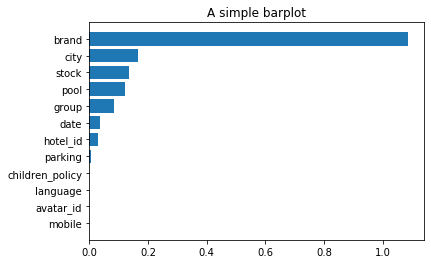

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a data frame
df = pd.DataFrame ({
        'Group':  features_importance2['Feature_name2'],
        'Value': features_importance2['Importance2']
})

# Sort the table
df = df.sort_values(by=['Value'])

# Create horizontal bars
plt.barh(y=df.Group, width=df.Value);

# Add title
plt.title('A simple barplot');

In [34]:
features_importance_dict['XGBoost']

,Feature_name,Importance
64,brand_Safitel,0.310683
54,brand_Corlton,0.231342
47,group_Independant,0.203731
1,stock,0.178171
53,brand_Chill Garden Inn,0.143026
...,...,...
20,language_croatian,0.000000
57,brand_Independant,0.000000
18,language_belgian,0.000000
35,language_luxembourgish,0.000000


In [39]:
Feature_name = features_importance_dict['XGBoost']['Feature_name'].tolist()
Importance_xgb = features_importance_dict['XGBoost']['Importance'].tolist()

Feature_name2 = ['city','language', 'group','brand','hotel_id','stock','date','mobile','avatar_id','parking','pool','children_policy']
Importance2_xgb = [0 for i in range(len(Feature_name2))]

for i in range(len(Feature_name)):
    if Feature_name[i][0:4]=='city':
        Importance2_xgb[0]=Importance2_xgb[0]+Importance_xgb[i]
    
    if Feature_name[i][0:8]=='language':
        Importance2_xgb[1]=Importance2_xgb[1]+Importance_xgb[i]  
   
    if Feature_name[i][0:5]=='group':
        Importance2_xgb[2]=Importance2_xgb[2]+Importance_xgb[i]  
        
    if Feature_name[i][0:5]=='brand':
        Importance2_xgb[3]=Importance2_xgb[3]+Importance_xgb[i]  

for j in range(4,len(Feature_name2)):
    Importance2_xgb[j]= Importance_xgb[Feature_name.index(Feature_name2[j])]     
        
Importance2_xgb   
features_importance2 = pd.DataFrame(list(zip(Feature_name2, Importance2_xgb)),columns =['Feature_name2', 'Importance2_xgb'])
features_importance2


,Feature_name2,Importance2_xgb
0,city,0.178885
1,language,0.002910
2,group,0.224502
3,brand,0.896600
4,hotel_id,0.041717
5,stock,0.178171
6,date,0.043712
7,mobile,0.000090
8,avatar_id,0.002863
9,parking,0.001658


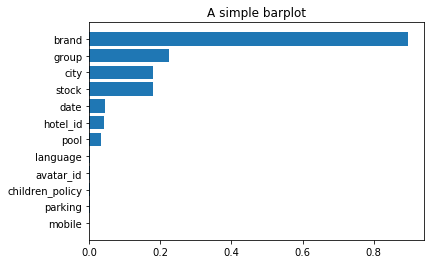

In [40]:
# Create a data frame
df = pd.DataFrame ({
        'Group':  features_importance2['Feature_name2'],
        'Value': features_importance2['Importance2_xgb']
})

# Sort the table
df = df.sort_values(by=['Value'])

# Create horizontal bars
plt.barh(y=df.Group, width=df.Value);

# Add title
plt.title('A simple barplot');

### Amélioration du modèle

On essaie d'améliorer le modèle en retirant les features peu importantes.

In [8]:
dataset2 = X_ohe

In [9]:
del dataset2['parking']
del dataset2['children_policy']
del dataset2['mobile']
del dataset2['avatar_id']
del dataset2['language_austrian']
del dataset2['language_belgian']
del dataset2['language_bulgarian']
del dataset2['language_croatian']
del dataset2['language_cypriot']
del dataset2['language_czech']
del dataset2['language_danish']
del dataset2['language_dutch']
del dataset2['language_estonian']
del dataset2['language_finnish']
del dataset2['language_french']
del dataset2['language_german']
del dataset2['language_greek']
del dataset2['language_hungarian']
del dataset2['language_irish']
del dataset2['language_italian']
del dataset2['language_latvian']
del dataset2['language_lithuanian']
del dataset2['language_luxembourgish']
del dataset2['language_maltese']
del dataset2['language_polish']
del dataset2['language_portuguese']
del dataset2['language_romanian']
del dataset2['language_slovakian']
del dataset2['language_slovene']
del dataset2['language_spanish']
del dataset2['language_swedish']

In [10]:
dataset2

,hotel_id,stock,date,pool,city_amsterdam,city_copenhagen,city_madrid,city_paris,city_rome,city_sofia,...,brand_Ibas,brand_Independant,brand_J.Halliday Inn,brand_Marcure,brand_Morriot,brand_Navatel,brand_Quadrupletree,brand_Royal Lotus,brand_Safitel,brand_Tripletree
0,918,23,14,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,442,19,14,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,588,0,14,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,807,17,14,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,271,0,14,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38857,272,0,7,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
38858,353,13,7,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
38859,304,19,7,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
38860,145,7,7,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [11]:
from sklearn.model_selection import train_test_split  

X_train2,X_test2,Y_train2,Y_test2=train_test_split(dataset2,Y_ohe,test_size=0.1)

In [14]:
rf.fit(X_train2, Y_train2)
print(f"Random forest score: {rf.score(X_test2, Y_test2):.2f}")

Random forest score: 0.89


In [16]:
xgb.fit(X_train2,Y_train2)
print(f"XGBoost score: {xgb.score(X_test2, Y_test2):.2f}")

XGBoost score: 0.99
